## Analyse des features d'une image

Jusqu'à présent nous nous sommes contenté de prendre les données d'une image puis, après un resize et une isolation du bleu, nous avons directement enfourné nos descripteurs dans les algorithmes d'apprentissage.
L'objectif de ce notebook et donc d'aller un peu plus loin dans le traitement préliminaire des données de nos images.

sources :
*Image processing tutorials - Yann Gavet, Johan Debayle. Passages intéressants : p56-57 denoising; p173 line detection; p255 Image Characterization and Pattern Analysis
*Le machine learning avec python - Andreas C. Müller, Sarah Guido.

On va faire une combinaison d'ensembles d'images pour essayer de faire ressortir des patterns.

In [14]:
import os
import matplotlib.pyplot as plt

In [19]:
def average_img(imlist):
    # source : https://stackoverflow.com/questions/17291455/how-to-get-an-average-picture-from-100-pictures-using-pil
    images = np.array([np.array(Image.open(fname).resize((1200, 1200)).convert("RGB")) for fname in imlist])
    arr = np.array(np.mean(images, axis=(0)), dtype=np.uint8)
    out = Image.fromarray(arr)
    return out

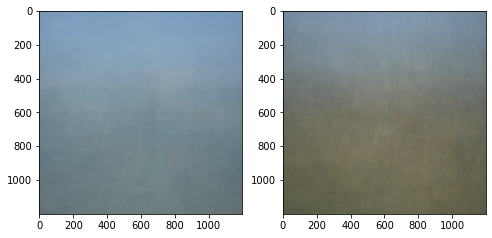

In [20]:
fig = plt.figure(figsize=(8, 8))
dump = fig.add_subplot((121))
imlist = ["./Data/Mer/" + fname for fname in os.listdir("./Data/Mer/")][:]
dump = plt.imshow(average_img(imlist))
dump = fig.add_subplot((122))
imlist = ["./Data/Ailleurs/" + fname for fname in os.listdir("./Data/Ailleurs/")][:]
dump = plt.imshow(average_img(imlist))

#### Observations :
* On voit que la detection de la mer implique de partir sur l'analyse des couleurs.
* On remarque que la différence la plus importante se situe les (environs) 80% inférieurs de l'image.

## On va donc tenter d'appliquer des filtres

### I Amelioration de l'image

En regardant l'échantillon, on remarque que les images de mers sont souvent bruités. On va appliquer un filtre passe bas de convolution pour éliminer ça.
Sources : https://en.wikipedia.org/wiki/Digital_image_processing#Filtering https://pillow.readthedocs.io/en/stable/reference/ImageFilter.html.

In [2]:
def denoise(image):
    return nd.median_filter(image, size=(20, 10, 1))

In [4]:
def segmentate(imarray):
    [nLines, nCols, channels] = imarray.shape
    data = np.reshape(imarray, (nLines * nCols, channels))
    k_means = KMeans(init="k-means++", n_clusters=4, n_init=10)
    k_means.fit(data)
    segmentation = 70 * np.reshape(k_means.labels_, (nLines, nCols))
    return segmentation

à faire :
    prendre un maximum de caractéristiques de l'image puis utiliser le SelectTransform de sklearn

caracteristiques recherchés :

[OK] quantité de bleu, rouge, vert côté inférieur (somme ou flood filling après denoise),
[OK] présence d'un horizon (Hough transform, line detection) :verticalité, horizontalité et transversalité des lignes détectées,
[OK] entropy,
combien de rectangles peut on placer dans l'image ?,
[OK] nombre de coins detectés dans l'image (on peut s'attendre à ce que la mer en ait moins) https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_corner.html#sphx-glr-auto-examples-features-detection-plot-corner-py,
euleur number (utilité jsp)
présence de reflection (??),
brillance (nb pixels blancs, ??),
[OK] luminosité,
Il n'y a presque jamais de rouge / de orange

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# mesure, transformation de l'image
from skimage import feature
from skimage import measure
from skimage import transform

# restoration et amelioration de l'image
from scipy import ndimage as nd
from sklearn.cluster import KMeans
from PIL import Image, ImageStat
from PIL import ImageStat

In [3]:
def standard_format(image):
    return image.resize((800, 800)).convert("RGB")

In [4]:
def compute_color_props(imarray):
    """
    imarray : image en format standard + RGB et de type ndarray
    """
    b = np.arange(256)
    n_tot = np.sum([imarray[..., 0], imarray[..., 1], imarray[..., 2]])
    hist_r = np.histogram(imarray[..., 0], bins=b)[0]
    hist_g = np.histogram(imarray[..., 1], bins=b)[0]
    hist_b = np.histogram(imarray[..., 2], bins=b)[0]
    rs = np.sum(np.multiply(hist_r, b[:-1]))
    gs = np.sum(np.multiply(hist_g, b[:-1]))
    bs = np.sum(np.multiply(hist_b, b[:-1]))
    return rs / n_tot, gs / n_tot, bs / n_tot

In [5]:
def angle_to_hori(p1, p2):
    # source : https://stackoverflow.com/questions/7586063/how-to-calculate-the-angle-between-a-line-and-the-horizontal-axis
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    theta = np.arctan2(dy, dx)
    return np.degrees(theta)


def compute_hvt_props(imarray):
    """
    Nécessite une image en mode gris
    """
    # source : https://scikit-image.org/docs/stable/auto_examples/edges/plot_line_hough_transform.html
    canny_imarray = feature.canny(imarray, 3, 1, 25)  # filtre pour retrouver les contours
    lines = transform.probabilistic_hough_line(canny_imarray, 10, 30, 5)
    h, v, t = 0, 0, 0
    for p0, p1 in lines:
        angle = np.abs(angle_to_hori(p0, p1))
        if 60 <= angle <= 120 or 240 <= angle <= 300:
            v += 1
        elif 0 <= angle <= 30 or 330 <= angle <= 360 or 150 <= angle <= 210:
            h += 1
        else:
            t += 1
    return h / len(lines), v / len(lines), t / len(lines)

In [6]:
def get_entropy(imarray):
    """
    Nécessite une image en mode gris
    """
    # source : https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.shannon_entropy
    # TODO penser à appliquer un Scaler sur les mesures d'entropies avant de les intégrer au model.
    return measure.shannon_entropy(imarray)

In [7]:
def brightness(pilmage):
    # source :
    stat = ImageStat.Stat(pilmage)
    r, g, b = stat.mean
    return np.sqrt(0.241 * (r ** 2) + 0.691 * (g ** 2) + 0.068 * (b ** 2))

In [8]:
def compute_nb_corners(imarray):
    # source : https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_corner.html#sphx-glr-auto-examples-features-detection-plot-corner-py
    return len(
        feature.corner_peaks(feature.corner_harris(imarray, k=0.02), min_distance=15, threshold_rel=0.02, num_peaks=50))

### Apprentissage

Marche pas :
    hog (trop de valeurs)
    region measures après segmentation
    flood filling

In [12]:
import descriptor

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [49]:
class FeaturesDescriptor(descriptor.OneInstanceBaseDescriptor):
    def __init__(self):
        # rajouter attributs si necessaire
        # self.att = att
        self.to_scales = [[], []]
        self.scaler = StandardScaler()
        super().__init__()

    def data_collect(self, image_path):
        # attention, il peut y avoir besoin de d'utiliser Image.fromarray() ou np.array() si il y a des erreurs
        pilmage = standard_format(Image.open(image_path))
        imarray = np.array(pilmage)
        imarray_denoised = denoise(pilmage)
        imarray_rgb = imarray
        imarray_L = pilmage.convert('L')
        imarray_L_denoised = np.array(Image.fromarray(imarray_denoised).convert('L'))
        features = []
        features += list(compute_color_props(imarray_rgb))
        features += list(compute_hvt_props(imarray_L_denoised))
        self.to_scales[0].append(get_entropy(imarray_L))
        self.to_scales[1].append(brightness(pilmage))
        return features

    def apply_scaler(self):
        for d in self.to_scales:
            scaled = self.scaler.fit_transform(np.array(d).reshape(-1, 1))
            for i, val in enumerate(scaled):
                self.X[i].append(val[0])

In [50]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])
param_grid = [
    {'classifier': [SVC()], 'preprocessing': [None],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10], 'classifier__C': [0.01, 0.1, 1, 10, 100]},

    {'classifier': [MLPClassifier()], 'preprocessing': [None],
     'classifier__activation': ['identity', 'logistic', 'tanh', 'relu'], 'classifier__solver': ['lbfgs', 'adam', 'sgd'],
     'classifier__max_iter': [500, 700, 1000]},

    {'classifier': [RandomForestClassifier()], 'preprocessing': [None],
     'classifier__criterion': ["gini", "entropy"], 'classifier__max_depth': [10, 50, None],
     "classifier__min_samples_split": [2, 5, 10]}
]

In [51]:
descr = FeaturesDescriptor()
descr.construct()

constructing descriptor..


100%|██████████| 207/207 [08:37<00:00,  2.50s/it]

done


In [52]:
descr.apply_scaler()

In [53]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
dump = descr.train_test_evaluate(grid, n_iter=1)
print(grid.best_params_, grid.best_score_)

evaluating..


  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\Yoyo\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Yoyo\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Yoyo\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron

done
{'classifier': RandomForestClassifier(min_samples_split=10), 'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_split': 10, 'preprocessing': None} 0.8363636363636363


denoise - entropy - brightness {'classifier': RandomForestClassifier(), 'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'preprocessing': None} 0.8606060606060606
standard - denoise - entropy - brightness {'classifier': MLPClassifier(max_iter=5000), 'classifier__activation': 'relu', 'classifier__max_iter': 5000, 'classifier__solver': 'adam', 'preprocessing': MinMaxScaler()} 0.8454545454545455
tout - RandomForestClassifier(min_samples_split=10)

In [59]:
print(descr.train_test_evaluate(RandomForestClassifier(min_samples_split=10), n_iter=50))
# print(descr.train_test_evaluate(MLPClassifier(max_iter=5000), n_iter=25))

evaluating..


100%|██████████| 50/50 [00:03<00:00, 12.61it/s]

done
0.8108433734939758


In [73]:
class RestoreDescriptor(descriptor.OneInstanceBaseDescriptor):

    def __init__(self):
        # rajouter attributs si necessaire
        # self.att = att
        super().__init__()

    def data_collect(self, image_path):
        # attention, il peut y avoir besoin de d'utiliser Image.fromarray() ou np.array() si il y a des erreurs
        image = self.images[image_path]
        image = standard_format(image)
        image = denoise(image)
        b = image.getchannel("B").histogram()
        g = image.getchannel("G").histogram()
        r = image.getchannel("R").histogram()
        return g + b

avec denoise :
0.8192771084337349
{'classifier': SVC(C=1, gamma=0.01), 'classifier__C': 1, 'classifier__gamma': 0.01, 'preprocessing': MinMaxScaler()}
test avec 100 iter : 0.764

sans denoise :
0.7951807228915663
{'classifier': SVC(C=100, gamma=0.001), 'classifier__C': 100, 'classifier__gamma': 0.001, 'preprocessing': MinMaxScaler()}

In [9]:
def angle_to_hori(p1, p2):
    # source : https://stackoverflow.com/questions/7586063/how-to-calculate-the-angle-between-a-line-and-the-horizontal-axis
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    theta = np.arctan2(dy, dx)
    return np.degrees(theta)


def compute_hvt_props(imarray):
    """
    Nécessite une image en mode gris
    """
    # source : https://scikit-image.org/docs/stable/auto_examples/edges/plot_line_hough_transform.html
    canny_imarray = feature.canny(imarray, 5, 1, 19)  # filtre pour retrouver les contours
    lines = transform.probabilistic_hough_line(canny_imarray, threshold=20, line_length=25)
    h, v, t = 0, 0, 0
    for p0, p1 in lines:
        angle = np.abs(angle_to_hori(p0, p1))
        if 60 <= angle <= 120 or 240 <= angle <= 300:
            v += 1
        elif 0 <= angle <= 30 or 330 <= angle <= 360 or 150 <= angle <= 210:
            h += 1
        else:
            t += 1
    return h / len(lines), v / len(lines), t / len(lines), canny_imarray, lines

0.4881889763779528 0.15748031496062992 0.3543307086614173


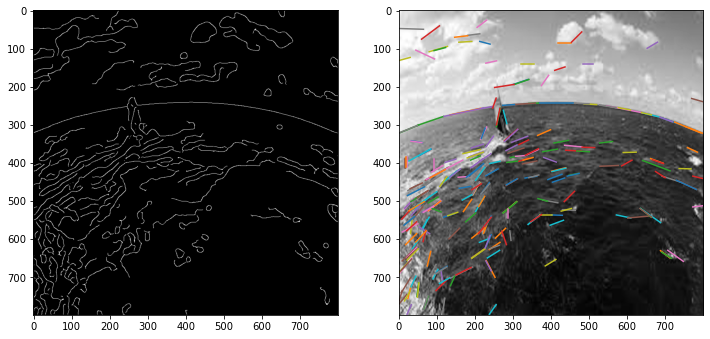

In [91]:
pilmage = standard_format(Image.open("Data/Mer/ccooyy.jpeg")).convert('L')
image = np.array(pilmage)
h, v, t, cannimarray, lines = compute_hvt_props(image)
plt.figure(figsize=(12, 8))
plt.subplot((121))
plt.imshow(cannimarray, cmap='gray')
print(h, v, t)
plt.subplot((122))
plt.imshow(image, cmap='gray')
for p0, p1 in lines:
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]))

In [85]:
xsmer_h = []
ysmer_v = []
zsmer_t = []
xsmer_r = []
ysmer_g = []
zsmer_b = []
k = 0
for impath in os.listdir("Data/Mer/"):
    img = standard_format(Image.open("Data/Mer/" + impath))
    imarray = np.array(img)
    r, g, b = compute_color_props(imarray)
    h, v, t, _, _ = compute_hvt_props(np.array(img.convert('L')))
    if h < 0.45:
        k += 1
        print(impath, h) # environ 5
    xsmer_h.append(h)
    ysmer_v.append(v)
    zsmer_t.append(t)
    xsmer_r.append(r)
    ysmer_g.append(g)
    zsmer_b.append(b)
print(k / 206)
print('##############')
xsail_h = []
ysail_v = []
zsail_t = []
xsail_r = []
ysail_g = []
zsail_b = []
k = 0
for impath in os.listdir("Data/Ailleurs/"):
    img = standard_format(Image.open("Data/Ailleurs/" + impath))
    imarray = np.array(img)
    r, g, b = compute_color_props(imarray)
    h, v, t, _, _ = compute_hvt_props(np.array(img.convert('L')))
    if h > 0.8:
        k += 1
        print(impath, h) # environ 15
    xsail_h.append(h)
    ysail_v.append(v)
    zsail_t.append(t)
    xsail_r.append(r)
    ysail_g.append(g)
    zsail_b.append(b)
print(k / 207)

azqmp00h.jpeg 0.30297723292469353
bP0.jpeg 0.2979683972911964
bsurfmm.jpeg 0.3372093023255814
ccooyy.jpeg 0.4253246753246753
cfr87jjui.jpg 0.2761904761904762
cqmwdc.jpeg 0.15841584158415842
dark8w.jpeg 0.359375
dma51.jpeg 0.4349593495934959
dp09h.jpeg 0.1106145251396648
fal0lv.jpeg 0.3416536661466459
gob81a.jpeg 0.23910171730515192
gtqmzb.jpeg 0.27400468384074944
js44.jpeg 0.0707070707070707
kbttt76.jpg 0.35471698113207545
kkoilu.jpeg 0.27647058823529413
lmpp.jpeg 0.3050239234449761
m1.jpeg 0.26405867970660146
m2.jpeg 0.24695652173913044
m3.jpeg 0.25544267053701014
m4.jpeg 0.07183908045977011
m5.jpeg 0.2962962962962963
mdsqa.jpeg 0.3923076923076923
mqabcf.jpeg 0.3352601156069364
n7.jpg 0.4327485380116959
nz9oom.jpeg 0.40695652173913044
oca88p.jpeg 0.43097643097643096
pluu.jpeg 0.40850277264325324
qspmr.jpeg 0.31637032495401596
qszt7.jpg 0.4280456385719544
rocjj.jpeg 0.33518005540166207
t7uu.jpeg 0.38895089285714285
TCHOME.jpg 0.3383137673425827
th98jq3.jpg 0.3965785381026439
v66.jpeg 0

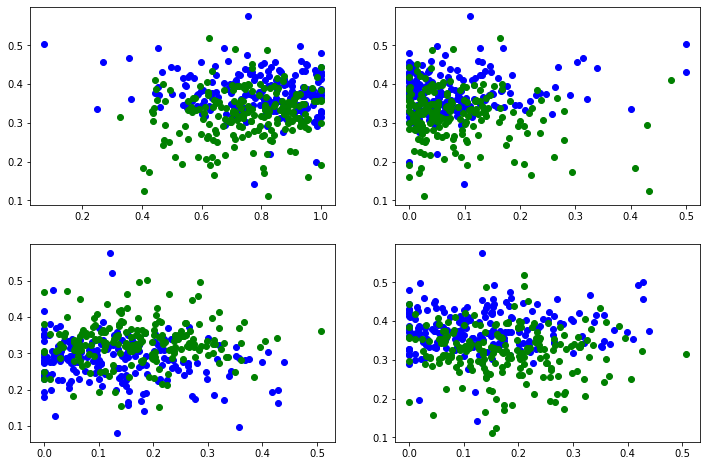

In [123]:
# modéle avec line_length=10 line-gap=10 pour hough lines et sans sandard format
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.scatter(xsmer_h, zsmer_b, c='b')
plt.scatter(xsail_h, zsail_b, c='g')
plt.subplot((222))
plt.scatter(ysmer_v, zsmer_b, c='b')
plt.scatter(ysail_v, zsail_b, c='g')
plt.subplot((223))
plt.scatter(zsmer_t, xsmer_r, c='b')
plt.scatter(zsail_t, xsail_r, c='g')
plt.subplot((224))
plt.scatter(zsmer_t, zsmer_b, c='b')
plt.scatter(zsail_t, zsail_b, c='g')

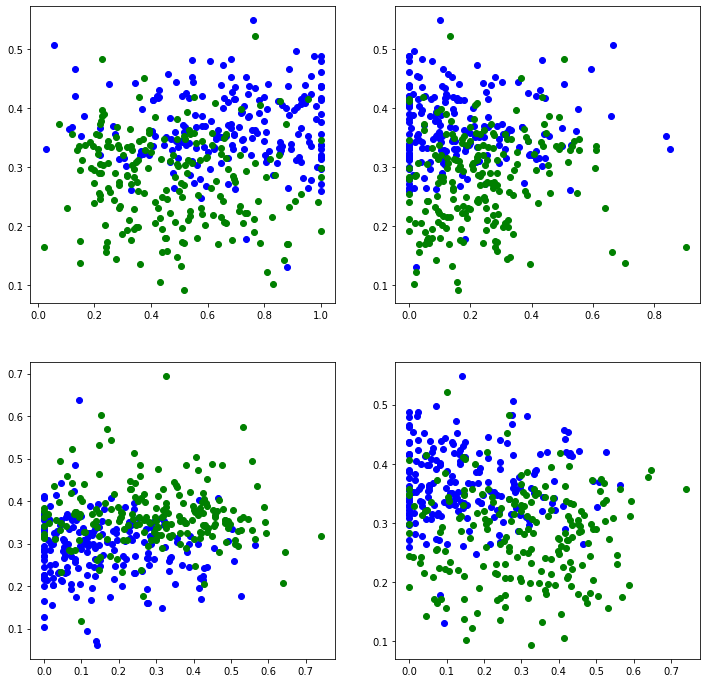

In [47]:
# modèle avec canny 4, 1, 25, hough line, standard format et en se concentrant sur le bas de l'image pour les couleurs
plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.scatter(xsmer_h, zsmer_b, c='b')
plt.scatter(xsail_h, zsail_b, c='g')
plt.subplot((222))
plt.scatter(ysmer_v, zsmer_b, c='b')
plt.scatter(ysail_v, zsail_b, c='g')
plt.subplot((223))
plt.scatter(zsmer_t, xsmer_r, c='b')
plt.scatter(zsail_t, xsail_r, c='g')
plt.subplot((224))
plt.scatter(zsmer_t, zsmer_b, c='b')
plt.scatter(zsail_t, zsail_b, c='g')

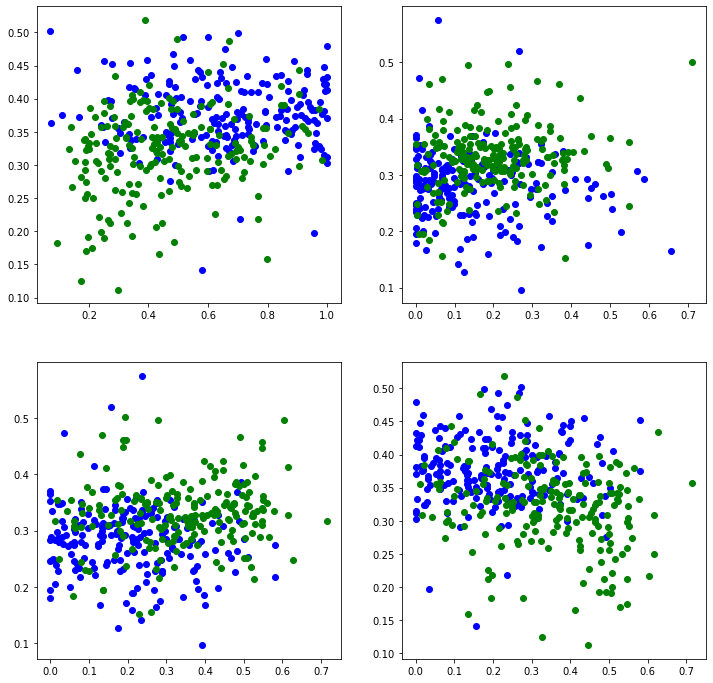

In [86]:
# modèle avec canny 4, 1, 25, hough line, standard format
plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.scatter(xsmer_h, zsmer_b, c='b')
plt.scatter(xsail_h, zsail_b, c='g')
plt.subplot((222))
plt.scatter(ysmer_v, xsmer_r, c='b')
plt.scatter(ysail_v, xsail_r, c='g')
plt.subplot((223))
plt.scatter(zsmer_t, xsmer_r, c='b')
plt.scatter(zsail_t, xsail_r, c='g')
plt.subplot((224))
plt.scatter(zsmer_t, zsmer_b, c='b')
plt.scatter(zsail_t, zsail_b, c='g')

h + b
v + b
t + r
t + b
~~ t + g
~~ v + r
! v + g
! b + r
! b + g

In [21]:
from tqdm import tqdm
def compute_data(X, y, directory, elementsClass):
    for file in tqdm(os.listdir(directory)):
        img = standard_format(Image.open(directory + "/" + file))
        imarray = np.array(img)
        r, g, b = compute_color_props(imarray)
        h, v, t, _, _ = compute_hvt_props(np.array(img.convert('L')))
        X.append([h, b])
        y.append(elementsClass)


X = []
y = []

compute_data(X, y, "./Data/Ailleurs", 0)
compute_data(X, y, "./Data/Mer", 1)

100%|██████████| 246/246 [00:33<00:00,  7.37it/s]


100%|██████████| 100/100 [00:07<00:00, 12.59it/s]


Moyenne : 0.768989898989899, Variance : 0.001384868890929497, Écart-type : 0.037213826609601666


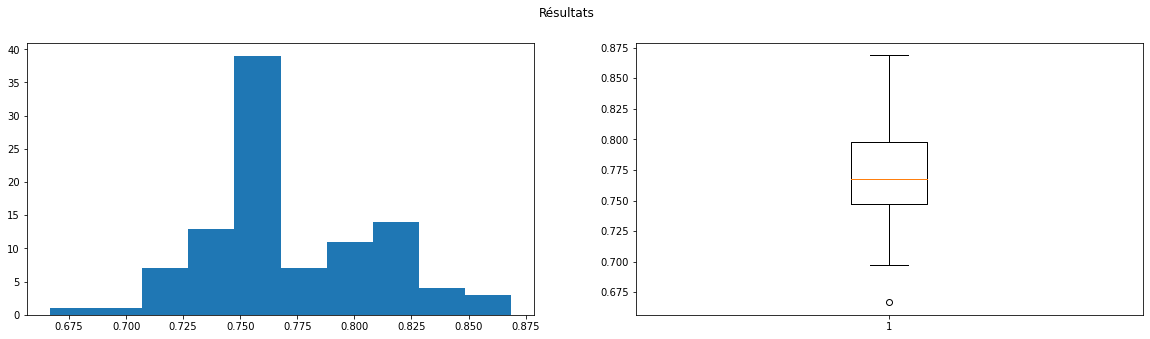

In [22]:
def plot_results(clf_scores):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    fig.suptitle('Résultats')
    ax1.hist(clf_scores)
    ax2.boxplot(clf_scores)

    print("Moyenne : " + str(np.mean(clf_scores)) + ", Variance : " + str(np.var(clf_scores)) + ", Écart-type : " + str(
        np.std(clf_scores)))


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

classifieur = RandomForestClassifier(min_samples_split=10)

nb_runs = 100
clf_scores = []
for i in tqdm(range(nb_runs)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    classifieur.fit(X_train, y_train)
    y_predits = classifieur.predict(X_test)
    clf_scores.append(accuracy_score(y_test, y_predits))
plot_results(clf_scores)